In [679]:
!pip install fbprophet

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import datetime as dt

import fbprophet
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [680]:
url1 = 'https://raw.githubusercontent.com/nghiale0811/sales-demand-forecasting/main/train.csv'
train  = pd.read_csv(url1)

url2 = 'https://raw.githubusercontent.com/nghiale0811/sales-demand-forecasting/main/test.csv'
test  = pd.read_csv(url2)

In [681]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [682]:
# get a univariate time series
df = pd.concat([train,test],sort=True)
ts = df[(df.item==1) & (df.store==1)].copy()

In [683]:
ts

,date,id,item,sales,store
0,2013-01-01,NaN,1,13.0,1
1,2013-01-02,NaN,1,11.0,1
2,2013-01-03,NaN,1,14.0,1
3,2013-01-04,NaN,1,13.0,1
4,2013-01-05,NaN,1,10.0,1
...,...,...,...,...,...
85,2018-03-27,85.0,1,NaN,1
86,2018-03-28,86.0,1,NaN,1
87,2018-03-29,87.0,1,NaN,1
88,2018-03-30,88.0,1,NaN,1


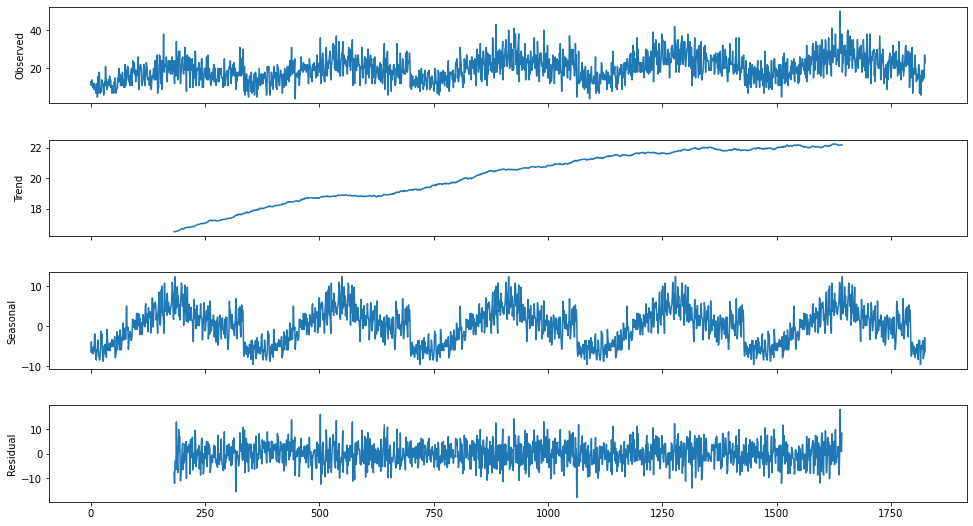

In [684]:
#visualization
res = sm.tsa.seasonal_decompose(ts.sales.dropna(),freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [685]:
#train_test_split
ts = ts.set_index('date').sort_index()
train_start,train_end = '2014-01-01','2017-09-30'
test_start,test_end = '2017-10-01','2017-12-31'
train_data = ts['sales'][train_start:train_end].dropna()
test_data = ts['sales'][test_start:test_end].dropna()

#Time series analysis

We will use the following model, and its parameters is, respectively: <br>


*   **ARMA**$(p, q)$
*   **ARIMA**$(p, d, q)$
*   **SARIMA**$(p, d, q)(P, D, Q)_s$
*   **ARIMAX**$(p, d, q)$ + Exogenous variable
*   **SARIMAX**$(p, d, q)(P, D, Q)_s$ + Exogenous variable


We need to check the stationarity assumption by using the Augmented Dickey-Fuller (ADF) test. Note that the option regression in $\texttt{sm.tsm.adfuller}$ can be specified by 'c' for constant, 'ct' for constant and trend, 'ctt' for constant, linear and quadratic trend, 'nc' for no constant, no trend.

In [686]:
#ADF-test (For original time series)
res = sm.tsa.adfuller(ts['sales'].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.07610688992415213


In [687]:
#ADF-test (For differenced time series)
res = sm.tsa.adfuller(ts['sales'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.2109276320438902e-23


We need to be mindful at which range of data would be used for predicting. The final result depends on which data are chosen

In [688]:
#ADF-test(Original time series)
res = sm.tsa.adfuller(ts['sales']['2015-01-01':].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.5620643402533362


In [689]:
#ADF-test(differenced time series)
res = sm.tsa.adfuller(ts['sales']['2015-01-01':].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:4.530417561586068e-22


The situation where the original time series is not stationary and the differenced time series is stationary is called the unit root process. We can apply ARIMA and SARIMA model for the unit root process. Next, we plot the ACF and PACF to estimate the parameters for ARIMA model.

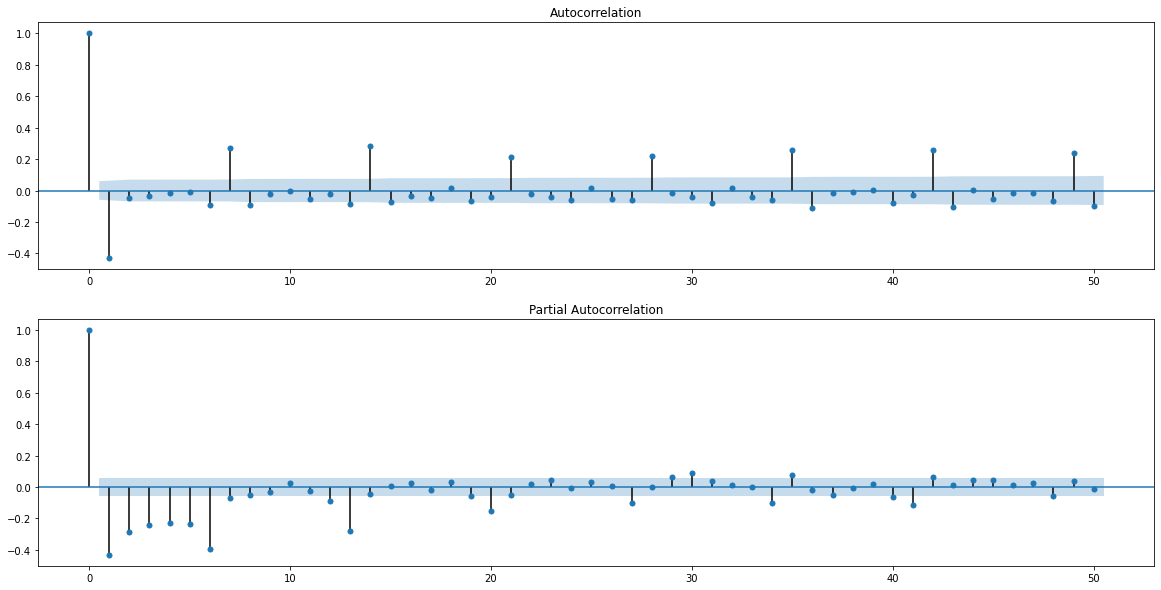

In [690]:
#we use tra.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ts['sales']['2015-01-01':].diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ts['sales']['2015-01-01':].diff().dropna(), lags=50, ax=ax[1])
plt.show()

From the plot, we can see that $p = 7$ and $d = 1$ (since the differenced time series is stationary). Now we need to find $q$.

In [691]:
%%script echo skipping
resDiff = sm.tsa.arma_order_select_ic(ts['sales']['2015-01-01':].dropna(), max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =', resDiff['aic_min_order'],'is the best.')

skipping


Hence, the parameters we need is $p = 7$, $d = 1$ and $q = 7$

## ARIMA

In [692]:
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0)
arima = sm.tsa.statespace.SARIMAX(ts['sales']['2015-01-01':].dropna(),order=(7,1,7),freq='D',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1096
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -3286.049
Date:                Sat, 07 May 2022   AIC                           6602.098
Time:                        06:45:52   BIC                           6676.966
Sample:                    01-01-2015   HQIC                          6630.437
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9629      0.046    -21.156      0.000      -1.052      -0.874
ar.L2         -0.9791      0.040    -24.618      0.000      -1.057      -0.901
ar.L3         -0.9759      0.043    -22.754      0.000      -1.060      -0.892
ar.L4         -0.9673      0.043    -22.508      0.000      -1.052      -0.883
ar.L5         -0.9861      0.040    -24.910      0.000      -1.064      -0.908
ar.L6         -0.9605      0.045    -21.123      0.000      -1.050      -0.871
ar.L7          0.0129      0.038      0.337      0.736      -0.062       0.088
ma.L1          0.0091      0.035      0.263      0.792      -0.059       0.077
ma.L2          0.1194      0.034      3.563      0.000       0.054       0.185
ma.L3          0.0549      0.035      1.557      0.119      -0.014       0.124
ma.L4          0.0594      0.034      1.751      0.080      -0.007       0.126
ma.L5          0.1191      0.034      3.477      0.001       0.052       0.186
ma.L6          0.0172      0.033      0.519      0.604      -0.048       0.082
ma.L7         -0.8554      0.035    -24.571      0.000      -0.924      -0.787
sigma2        24.6806      1.184     20.847      0.000      22.360      27.001
===================================================================================
Ljung-Box (Q):                       58.46   Jarque-Bera (JB):                 7.47
Prob(Q):                              0.03   Prob(JB):                         0.02
Heteroskedasticity (H):               1.02   Skew:                             0.15
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can observe that the value of the residual gradually decreases for further lags. Hence, the ARIMA model might be a good fit for our data.

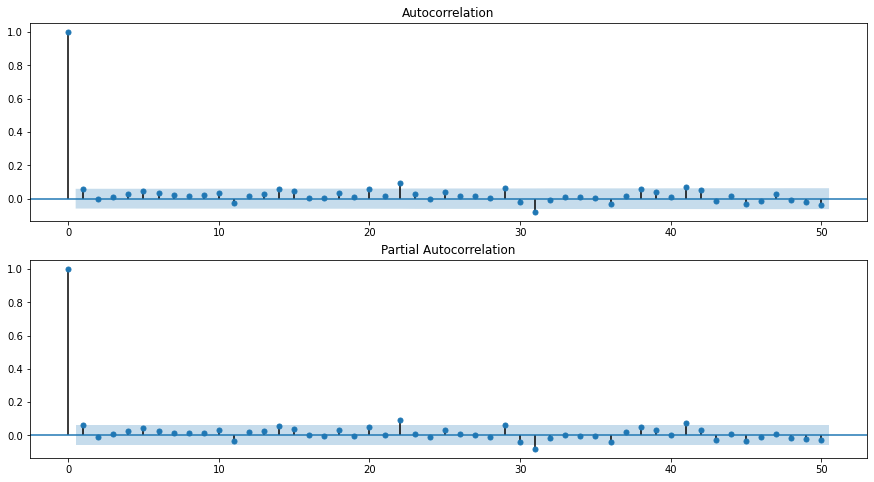

In [693]:
#ACF and PACF
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [694]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(train_end,test_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(test_data, pred)))

ARIMA model MSE:24.291453306001994


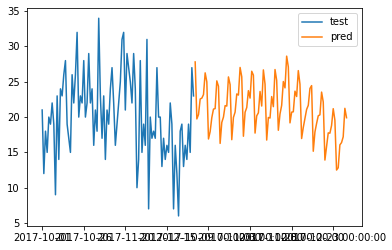

In [695]:
pd.DataFrame({'test':test_data,'pred':pred}).plot();
plt.show()

## SARIMA

We first try with period 1, i.e $(P, D, Q)_s = (7, 1, 7)$ with $s = 1$

In [696]:
sarima = sm.tsa.statespace.SARIMAX(ts['sales']['2015-01-01':].dropna(), order=(7,1,7), seasonal_order=(7,1,7,1),
                                enforce_stationarity=False, enforce_invertibility=False, freq='D').fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1096
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 1)   Log Likelihood               -3282.862
Date:                           Sat, 07 May 2022   AIC                           6623.724
Time:                                   06:46:24   BIC                           6768.254
Sample:                               01-01-2015   HQIC                          6678.453
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9182      2.122     -0.433      0.665      -5.078       3.242
ar.L2         -0.8937      2.205     -0.405      0.685      -5.215       3.428
ar.L3         -0.8991      2.325     -0.387      0.699      -5.456       3.658
ar.L4         -0.9000      2.345     -0.384      0.701      -5.496       3.696
ar.L5         -0.8953      2.100     -0.426      0.670      -5.012       3.221
ar.L6         -0.8820      1.846     -0.478      0.633      -4.499       2.735
ar.L7          0.0372      1.731      0.021      0.983      -3.356       3.431
ma.L1         -0.1039      0.046     -2.275      0.023      -0.193      -0.014
ma.L2         -0.0518      0.052     -1.003      0.316      -0.153       0.049
ma.L3         -0.0839      0.046     -1.842      0.065      -0.173       0.005
ma.L4         -0.0654      0.041     -1.594      0.111      -0.146       0.015
ma.L5         -0.0064      0.039     -0.164      0.870      -0.083       0.070
ma.L6         -0.0505      0.040     -1.267      0.205      -0.129       0.028
ma.L7         -0.9500      0.042    -22.784      0.000      -1.032      -0.868
ar.S.L1       -0.9134      2.101     -0.435      0.664      -5.030       3.204
ar.S.L2       -0.9164      2.205     -0.416      0.678      -5.238       3.405
ar.S.L3       -0.8953      2.349     -0.381      0.703      -5.499       3.708
ar.S.L4       -0.8804      2.329     -0.378      0.705      -5.446       3.685
ar.S.L5       -0.9086      2.081     -0.437      0.662      -4.986       3.169
ar.S.L6       -0.8981      1.880     -0.478      0.633      -4.583       2.787
ar.S.L7        0.0585      1.807      0.032      0.974      -3.482       3.599
ma.S.L1       -0.1039      0.046     -2.274      0.023      -0.193      -0.014
ma.S.L2       -0.0518      0.052     -1.003      0.316      -0.153       0.049
ma.S.L3       -0.0839      0.046     -1.842      0.065      -0.173       0.005
ma.S.L4       -0.0654      0.041     -1.594      0.111      -0.146       0.015
ma.S.L5       -0.0064      0.039     -0.164      0.870      -0.083       0.070
ma.S.L6       -0.0505      0.040     -1.267      0.205      -0.129       0.028
ma.S.L7       -0.9500      0.042    -22.784      0.000      -1.032      -0.868
sigma2        21.8841      1.166     18.762      0.000      19.598      24.170
===================================================================================
Ljung-Box (Q):                       45.25   Jarque-Bera (JB):                 4.28
Prob(Q):                              0.26   Prob(JB):                         0.12
Heteroskedasticity (H):               1.04   Skew:                             0.12
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covarianc

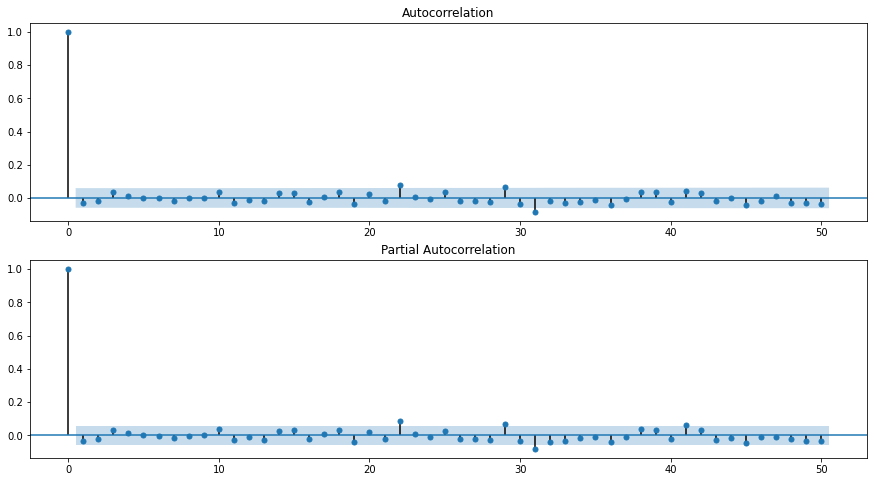

In [697]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [698]:
from sklearn.metrics import mean_squared_error
pred = sarima.predict(train_end,test_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_data,pred)))

SARIMA model MSE:23.873541605248114


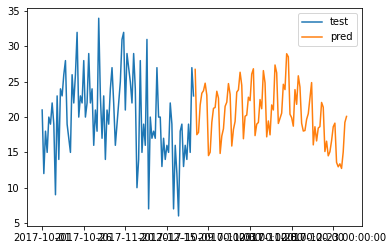

In [699]:
pd.DataFrame({'test':test_data,'pred':pred}).plot();
plt.show()

##Prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


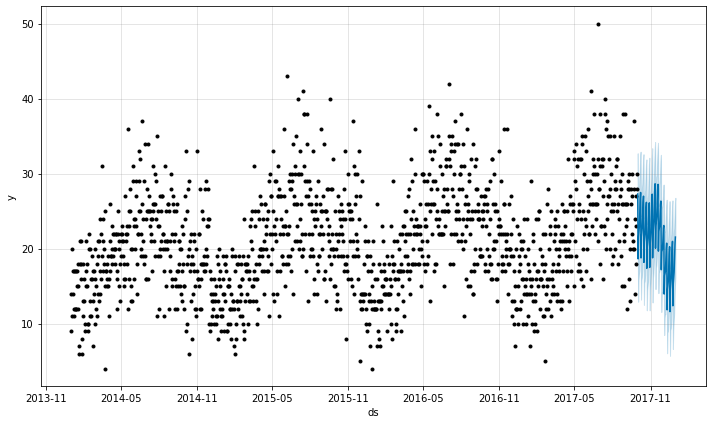

In [700]:
m = Prophet()

train_data_2 = train_data.reset_index(level=0)
train_data_2.columns = ['ds', 'y']

test_data_2 = test_data.reset_index(level=0)
test_data_2.columns = ['ds', 'y']

m.fit(train_data_2)
forecast = m.predict(test_data_2)
fig1 = m.plot(forecast)

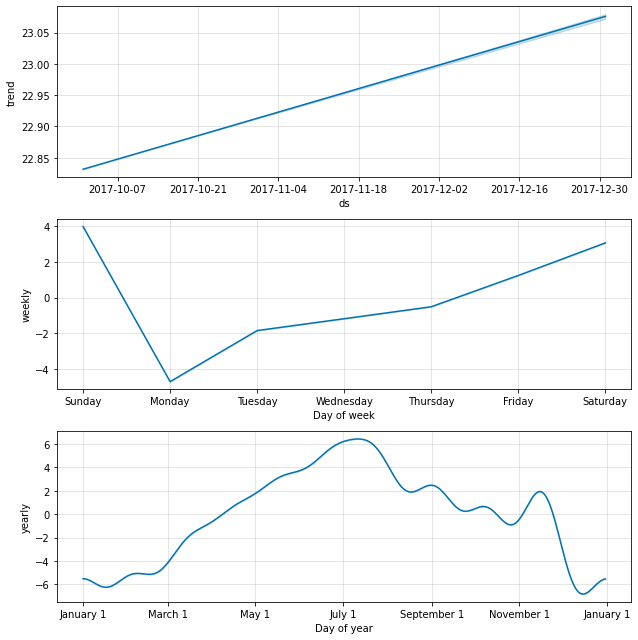

In [701]:
m.plot_components(forecast);

In [702]:
test_data_2

,ds,y
0,2017-10-01,21.0
1,2017-10-02,12.0
2,2017-10-03,18.0
3,2017-10-04,15.0
4,2017-10-05,20.0
...,...,...
87,2017-12-27,14.0
88,2017-12-28,19.0
89,2017-12-29,15.0
90,2017-12-30,27.0


In [703]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#diagnostic
metric_df = pd.concat([forecast, test_data_2], axis=1)[["y", "yhat"]]
metric_df.dropna(inplace=True)

metric_df

,y,yhat
0,21.0,27.283330
1,12.0,18.626044
2,18.0,21.544044
3,15.0,22.251998
4,20.0,22.955942
...,...,...
87,14.0,16.115511
88,19.0,16.871986
89,15.0,18.699719
90,27.0,20.582161


In [704]:
#R^2
r2_score(metric_df.y, metric_df.yhat)

0.3538556464901601

In [705]:
#MSE
mean_squared_error(metric_df.y, metric_df.yhat)

21.914172019633874

In [706]:
#MAE
mean_absolute_error(metric_df.y, metric_df.yhat)

3.873841185975743

## Multilayer perceptron

In [707]:
train['date'] = train['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
test['date'] = test['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [708]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

In [709]:
train

,date,store,item,sales,day,month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013
4,2013-01-05,1,1,10,5,1,2013
...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017
912996,2017-12-28,10,50,59,28,12,2017
912997,2017-12-29,10,50,74,29,12,2017
912998,2017-12-30,10,50,62,30,12,2017


In [710]:
epochs = 40
batch = 256
lr = 0.0003
adam = keras.optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=train.shape[1] - 2))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               600       
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [711]:
X_train = train[train.columns[~train.columns.isin(['sales','date'])]].astype(np.int32)
y_train = train["sales"].astype(np.int32)
mlp = model_mlp.fit(X_train, y_train, epochs=epochs, verbose=2)

Epoch 1/40
28532/28532 - 38s - loss: 798.9794 - 38s/epoch - 1ms/step
Epoch 2/40
28532/28532 - 40s - loss: 770.2802 - 40s/epoch - 1ms/step
Epoch 3/40
28532/28532 - 38s - loss: 767.3550 - 38s/epoch - 1ms/step
Epoch 4/40
28532/28532 - 39s - loss: 748.6496 - 39s/epoch - 1ms/step
Epoch 5/40
28532/28532 - 38s - loss: 697.5872 - 38s/epoch - 1ms/step
Epoch 6/40
28532/28532 - 38s - loss: 687.6815 - 38s/epoch - 1ms/step
Epoch 7/40
28532/28532 - 38s - loss: 682.5346 - 38s/epoch - 1ms/step
Epoch 8/40
28532/28532 - 38s - loss: 679.4740 - 38s/epoch - 1ms/step
Epoch 9/40
28532/28532 - 38s - loss: 676.8249 - 38s/epoch - 1ms/step
Epoch 10/40
28532/28532 - 38s - loss: 673.9853 - 38s/epoch - 1ms/step
Epoch 11/40
28532/28532 - 38s - loss: 671.8046 - 38s/epoch - 1ms/step
Epoch 12/40
28532/28532 - 39s - loss: 670.1091 - 39s/epoch - 1ms/step
Epoch 13/40
28532/28532 - 38s - loss: 668.2121 - 38s/epoch - 1ms/step
Epoch 14/40
28532/28532 - 38s - loss: 666.2280 - 38s/epoch - 1ms/step
Epoch 15/40
28532/28532 - 38s

## Convolutional Neural Network (CNN)



In [712]:
X_train_series = X_train.values.reshape((X_train.shape[0], -1, 1))

In [713]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                6450      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
____________________________________________________

In [714]:
cnn = model_cnn.fit(X_train_series, y_train, epochs=epochs, verbose=2)

Epoch 1/40
28532/28532 - 46s - loss: 753.4568 - 46s/epoch - 2ms/step
Epoch 2/40
28532/28532 - 59s - loss: 643.9768 - 59s/epoch - 2ms/step
Epoch 3/40
28532/28532 - 58s - loss: 603.7672 - 58s/epoch - 2ms/step
Epoch 4/40
28532/28532 - 50s - loss: 582.2058 - 50s/epoch - 2ms/step
Epoch 5/40
28532/28532 - 42s - loss: 568.8325 - 42s/epoch - 1ms/step
Epoch 6/40
28532/28532 - 43s - loss: 557.6154 - 43s/epoch - 2ms/step
Epoch 7/40
28532/28532 - 42s - loss: 549.3115 - 42s/epoch - 1ms/step
Epoch 8/40
28532/28532 - 47s - loss: 543.8334 - 47s/epoch - 2ms/step
Epoch 9/40
28532/28532 - 46s - loss: 539.2084 - 46s/epoch - 2ms/step
Epoch 10/40
28532/28532 - 56s - loss: 536.3652 - 56s/epoch - 2ms/step
Epoch 11/40
28532/28532 - 52s - loss: 533.9535 - 52s/epoch - 2ms/step
Epoch 12/40
28532/28532 - 51s - loss: 531.1520 - 51s/epoch - 2ms/step
Epoch 13/40
28532/28532 - 49s - loss: 528.2473 - 49s/epoch - 2ms/step
Epoch 14/40
28532/28532 - 48s - loss: 525.7381 - 48s/epoch - 2ms/step
Epoch 15/40
28532/28532 - 45s

## Long Short-Term Memory (LSTM)

In [715]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [716]:
lstm = model_lstm.fit(X_train_series, y_train, epochs=epochs, verbose=2)

Epoch 1/40
28532/28532 - 105s - loss: 626.8792 - 105s/epoch - 4ms/step
Epoch 2/40
28532/28532 - 102s - loss: 518.2112 - 102s/epoch - 4ms/step
Epoch 3/40
28532/28532 - 99s - loss: 483.4965 - 99s/epoch - 3ms/step
Epoch 4/40
28532/28532 - 100s - loss: 451.9454 - 100s/epoch - 4ms/step
Epoch 5/40
28532/28532 - 100s - loss: 445.0247 - 100s/epoch - 3ms/step
Epoch 6/40
28532/28532 - 100s - loss: 415.4118 - 100s/epoch - 4ms/step
Epoch 7/40
28532/28532 - 105s - loss: 383.3302 - 105s/epoch - 4ms/step
Epoch 8/40
28532/28532 - 101s - loss: 364.5554 - 101s/epoch - 4ms/step
Epoch 9/40
28532/28532 - 99s - loss: 347.2736 - 99s/epoch - 3ms/step
Epoch 10/40
28532/28532 - 100s - loss: 327.5079 - 100s/epoch - 4ms/step
Epoch 11/40
28532/28532 - 98s - loss: 309.2932 - 98s/epoch - 3ms/step
Epoch 12/40
28532/28532 - 101s - loss: 295.1651 - 101s/epoch - 4ms/step
Epoch 13/40
28532/28532 - 101s - loss: 285.3987 - 101s/epoch - 4ms/step
Epoch 14/40
28532/28532 - 99s - loss: 284.7012 - 99s/epoch - 3ms/step
Epoch 15/

## CNN + LSTM

In [720]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))

In [721]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [722]:
cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, y_train, epochs=epochs, verbose=2)

Epoch 1/40
28532/28532 - 73s - loss: 805.2680 - 73s/epoch - 3ms/step
Epoch 2/40
28532/28532 - 74s - loss: 762.1086 - 74s/epoch - 3ms/step
Epoch 3/40
28532/28532 - 74s - loss: 750.3818 - 74s/epoch - 3ms/step
Epoch 4/40
28532/28532 - 70s - loss: 746.9261 - 70s/epoch - 2ms/step
Epoch 5/40
28532/28532 - 71s - loss: 741.7994 - 71s/epoch - 2ms/step
Epoch 6/40
28532/28532 - 69s - loss: 725.8451 - 69s/epoch - 2ms/step
Epoch 7/40
28532/28532 - 70s - loss: 709.5344 - 70s/epoch - 2ms/step
Epoch 8/40
28532/28532 - 70s - loss: 681.6620 - 70s/epoch - 2ms/step
Epoch 9/40
28532/28532 - 74s - loss: 654.4267 - 74s/epoch - 3ms/step
Epoch 10/40
28532/28532 - 75s - loss: 622.5470 - 75s/epoch - 3ms/step
Epoch 11/40
28532/28532 - 75s - loss: 607.3168 - 75s/epoch - 3ms/step
Epoch 12/40
28532/28532 - 70s - loss: 602.4496 - 70s/epoch - 2ms/step
Epoch 13/40
28532/28532 - 73s - loss: 599.4656 - 73s/epoch - 3ms/step
Epoch 14/40
28532/28532 - 74s - loss: 597.1338 - 74s/epoch - 3ms/step
Epoch 15/40
28532/28532 - 75s